# **About Dataset:**

The task is to predict the day price direction of Amazon.com, Inc. (AMZN) stock.

The stock market is very complex and highly volatile. In order to be profitable, we do not need to predict the correct price, but rather, the price direction: whether it will be higher or lower than the price that is today. If we predict it to be higher, we might as well buy some stocks, else, we should probably sell.

Therefore, the target would be a binary classification whether the next day closing price will be higher than the opening price.

Data link: https://www.kaggle.com/datasets/harshalpanchal/amazon-stock-prices-dataset?resource=download

An analysis of a machine learning project aimed at predicting the day-to-day price direction of Amazon.com, Inc. (AMZN) stock. The objective was to develop models that could accurately forecast whether the next day's closing price would be higher or lower than the opening price. This binary classification approach aligns with the goal of informing buy or sell decisions in the stock market.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, HoverTool, CDSView, BooleanFilter
from bokeh.layouts import row, column
from bokeh.palettes import Spectral4, Spectral10
from bokeh.layouts import gridplot
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from bokeh.plotting import figure, show
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_df = pd.read_csv("/content/drive/MyDrive/amazon_stock_price/AMZN_train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/amazon_stock_price/AMZN_test.csv")
val_df = pd.read_csv("/content/drive/MyDrive/amazon_stock_price/AMZN_val.csv")

In [4]:
train_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200


In [5]:
val_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-05-16,710.130005,713.250000,700.280029,710.659973,710.659973,5432900
1,2016-05-17,709.900024,714.469971,693.909973,695.270020,695.270020,5121400
2,2016-05-18,689.559998,702.539978,688.760010,697.450012,697.450012,4283200
3,2016-05-19,691.880005,699.400024,689.559998,698.520020,698.520020,3025600
4,2016-05-20,701.049988,707.239990,700.000000,702.799988,702.799988,2916200


In [6]:
test_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-05-15,1587.800049,1587.800049,1565.219971,1576.119995,1576.119995,5077500
1,2018-05-16,1577.500000,1594.430054,1576.670044,1587.280029,1587.280029,2570600
2,2018-05-17,1580.560059,1594.040039,1573.000000,1581.760010,1581.760010,2147600
3,2018-05-18,1581.329956,1583.589966,1572.099976,1574.369995,1574.369995,2642600
4,2018-05-21,1585.000000,1592.050049,1575.000000,1585.459961,1585.459961,2925200


In [7]:
def plot_stock_price(df, title):
    output_notebook()
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')
    df.set_index('Date', inplace=True)

    source = ColumnDataSource(df)
    p = figure(x_axis_type="datetime", title=title, width=800, height=400)
    p.line(x='Date', y='Close', source=source, line_width=2, color='blue', legend_label='Close')
    p.line(x='Date', y='Open', source=source, line_width=2, color='red', legend_label='Open')
    p.legend.location="top_left"
    p.xaxis.axis_label="Date"
    p.yaxis.axis_label="Price (USD)"
    p.add_tools(HoverTool(
        tooltips=[
            ("Date", "@Date{%F}"),
            ("Close", "@Close{$0.2f}"),
            ("Open", "@Open{$0.2f}"),
        ],
        formatters={
            'Date' : 'datetime'
        }
    ))
    show(p)

In [8]:
plot_stock_price(train_df, "Amazon Stock Prices (Training)")
plot_stock_price(val_df, "Amazon Stock Prices (Validation)")
plot_stock_price(test_df, "Amazon Stock Prices (Test)")

# **Feature Engineering**

The project utilized historical stock price data for Amazon, split into training, validation, and test sets. The data included daily open, high, low, close, adjusted close prices, and trading volume. To enhance the predictive power of the models, several engineered features were created, including day percentage change, high-low percentage, open-close percentage, and various moving averages (5-day, 10-day, 15-day, and 20-day).

In [9]:
# Function to create features
def create_features(df):
    df['Day_Pct_Change'] = (df['Close'] - df['Open']) / df['Open'] * 100
    df['High_Low_Pct'] = (df['High'] - df['Low']) / df['Low'] * 100
    df['Open_Close_Pct'] = (df['Close'] - df['Open']) / df['Open'] * 100
    df['Moving_Avg_5'] = df['Close'].rolling(window=5).mean()
    df['Moving_Avg_10'] = df['Close'].rolling(window=10).mean()
    df['Moving_Avg_15'] = df['Close'].rolling(window=15).mean()
    df['Moving_Avg_20'] = df['Close'].rolling(window=20).mean()

    # Drop rows with NaN values
    df = df.dropna()

    return df


train_df = create_features(train_df)
val_df = create_features(val_df)
test_df = create_features(test_df)


In [10]:
train_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Day_Pct_Change,High_Low_Pct,Open_Close_Pct,Moving_Avg_5,Moving_Avg_10,Moving_Avg_15,Moving_Avg_20
19,1997-06-12,1.583333,1.645833,1.552083,1.604167,1.604167,1632000,1.315832,6.040270,1.315832,1.614583,1.552083,1.535764,1.574740
20,1997-06-13,1.625000,1.625000,1.583333,1.583333,1.583333,693600,-2.564123,2.631601,-2.564123,1.600000,1.560417,1.548264,1.555990
21,1997-06-16,1.604167,1.604167,1.562500,1.572917,1.572917,913200,-1.948052,2.666688,-1.948052,1.577083,1.566667,1.553125,1.548177
22,1997-06-17,1.598958,1.598958,1.494792,1.505208,1.505208,4706400,-5.863193,6.968595,-5.863193,1.561458,1.569271,1.547917,1.538021
23,1997-06-18,1.520833,1.536458,1.500000,1.510417,1.510417,2464800,-0.684888,2.430533,-0.684888,1.555208,1.578646,1.546528,1.531771


# **Create Target**

In [11]:
def create_target(df):
    df['Target'] = (df['Close'].shift(-1) > df['Open'].shift(-1)).astype(int)
    return df

train_df = create_target(train_df)
val_df = create_target(val_df)
test_df = create_target(test_df)

# Drop the last row as it doesn't have a target
train_df = train_df[:-1]
val_df = val_df[:-1]
test_df = test_df[:-1]


In [12]:
X_train = train_df[['Day_Pct_Change', 'High_Low_Pct', 'Open_Close_Pct', 'Moving_Avg_5', 'Moving_Avg_10', 'Moving_Avg_15', 'Moving_Avg_20']]
y_train = train_df['Target']

X_val = val_df[['Day_Pct_Change', 'High_Low_Pct', 'Open_Close_Pct', 'Moving_Avg_5', 'Moving_Avg_10', 'Moving_Avg_15', 'Moving_Avg_20']]
y_val = val_df['Target']

X_test = test_df[['Day_Pct_Change', 'High_Low_Pct', 'Open_Close_Pct', 'Moving_Avg_5', 'Moving_Avg_10', 'Moving_Avg_15', 'Moving_Avg_20']]
y_test = test_df['Target']


# **Model Training**

Three machine learning models were implemented and evaluated: Logistic Regression, Naive Bayes, and XGBoost. The performance of these models was assessed using accuracy scores and classification reports, which provide precision, recall, and F1-scores for both the validation and test datasets.

# **Logistic Regression**

In [13]:
# Initialize the model
model = LogisticRegression()

# Train the model
model.fit(X_train, y_train)

# Predictions
y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)

# Evaluate the model
print("Validation Accuracy: ", accuracy_score(y_val, y_pred_val))
print("Test Accuracy: ", accuracy_score(y_test, y_pred_test))

print("\nClassification Report (Validation):\n", classification_report(y_val, y_pred_val))
print("\nClassification Report (Test):\n", classification_report(y_test, y_pred_test))


Validation Accuracy:  0.5175983436853002
Test Accuracy:  0.5103305785123967

Classification Report (Validation):
               precision    recall  f1-score   support

           0       0.51      0.98      0.68       247
           1       0.62      0.03      0.06       236

    accuracy                           0.52       483
   macro avg       0.57      0.51      0.37       483
weighted avg       0.56      0.52      0.38       483


Classification Report (Test):
               precision    recall  f1-score   support

           0       0.51      0.94      0.66       244
           1       0.55      0.07      0.13       240

    accuracy                           0.51       484
   macro avg       0.53      0.51      0.39       484
weighted avg       0.53      0.51      0.39       484



In [14]:
output_notebook()

val_df['Predicted'] = y_pred_val
test_df['Predicted'] = y_pred_test

source_val = ColumnDataSource(val_df)
source_test = ColumnDataSource(test_df)

boolean_filter_val = BooleanFilter(val_df['Predicted'] == 1)
view_val = CDSView(source=source_val, filters=[boolean_filter_val])

boolean_filter_test = BooleanFilter(test_df['Predicted'] == 1)
view_test = CDSView(source=source_test, filters=[boolean_filter_test])

# Validation Plot
p_val = figure(x_axis_type='datetime', title='AMZN Stock Predictions - Validation')
p_val.line('Date', 'Close', source=source_val, color='blue', legend_label='Actual Close Price')
p_val.circle('Date', 'Close', size=5, source=source_val, color='green', legend_label='Predicted Up', view=view_val)

p_val.add_tools(HoverTool(tooltips=[("Date", "@Date{%F}"), ("Close", "@Close{0.2f}"), ("Prediction", "@Predicted")],
                  formatters={'@Date': 'datetime'}, mode='vline'))

p_val.legend.location = 'top_left'
p_val.xaxis.axis_label = 'Date'
p_val.yaxis.axis_label = 'Close Price'

show(p_val)

# Test Plot (similar to validation plot)
p_test = figure(x_axis_type='datetime', title='AMZN Stock Predictions - Test')
p_test.line('Date', 'Close', source=source_test, color='blue', legend_label='Actual Close Price')
p_test.circle('Date', 'Close', size=5, source=source_test, color='green', legend_label='Predicted Up', view=view_test)

p_test.add_tools(HoverTool(tooltips=[("Date", "@Date{%F}"), ("Close", "@Close{0.2f}"), ("Prediction", "@Predicted")],
                  formatters={'@Date': 'datetime'}, mode='vline'))

p_test.legend.location = 'top_left'
p_test.xaxis.axis_label = 'Date'
p_test.yaxis.axis_label = 'Close Price'

show(p_test)


In [15]:
# Predicting for the next day in the validation and test datasets
next_day_prediction_val = model.predict(X_val[-1:])[0]
next_day_prediction_test = model.predict(X_test[-1:])[0]

# Print statements for the predictions
print("Prediction for the next day in the validation dataset: ",
      "Up" if next_day_prediction_val == 1 else "Down")

print("Prediction for the next day in the test dataset: ",
      "Up" if next_day_prediction_test == 1 else "Down")


Prediction for the next day in the validation dataset:  Down
Prediction for the next day in the test dataset:  Down


# **The Results of Logistic Regression:**

Logistic Regression Model:

The logistic regression model achieved a validation accuracy of 51.76% and a test accuracy of 51.03%. While these results are slightly better than random guessing, they indicate limited predictive power. The classification reports reveal that the model performed better at predicting downward movements (class 0) compared to upward movements (class 1), with higher precision and recall for the former.

For the next-day predictions on the validation and test dataset for Logistic Regression model forecasted a downward movement. This alignment in predictions might suggest a stronger signal for a potential price decrease, although the overall model accuracies warrant caution in interpretation.

# **Naive Bayes Model**

In [16]:
# Initialize the Naive Bayes model
nb_model = GaussianNB()

# Train the model
nb_model.fit(X_train, y_train)

# Predictions
y_pred_val_nb = nb_model.predict(X_val)
y_pred_test_nb = nb_model.predict(X_test)

# Evaluate the model
print("Naive Bayes Validation Accuracy: ", accuracy_score(y_val, y_pred_val_nb))
print("Naive Bayes Test Accuracy: ", accuracy_score(y_test, y_pred_test_nb))

print("\nNaive Bayes Classification Report (Validation):\n", classification_report(y_val, y_pred_val_nb))
print("\nNaive Bayes Classification Report (Test):\n", classification_report(y_test, y_pred_test_nb))


Naive Bayes Validation Accuracy:  0.5113871635610766
Naive Bayes Test Accuracy:  0.5041322314049587

Naive Bayes Classification Report (Validation):
               precision    recall  f1-score   support

           0       0.51      1.00      0.68       247
           1       0.00      0.00      0.00       236

    accuracy                           0.51       483
   macro avg       0.26      0.50      0.34       483
weighted avg       0.26      0.51      0.35       483


Naive Bayes Classification Report (Test):
               precision    recall  f1-score   support

           0       0.50      1.00      0.67       244
           1       0.00      0.00      0.00       240

    accuracy                           0.50       484
   macro avg       0.25      0.50      0.34       484
weighted avg       0.25      0.50      0.34       484



In [17]:
val_df['Predicted_NB'] = y_pred_val_nb
source_nb = ColumnDataSource(val_df)

boolean_filter_nb = BooleanFilter(val_df['Predicted_NB'] == 1)
view_nb = CDSView(source=source_nb, filters=[boolean_filter_nb])

p_nb = figure(x_axis_type='datetime', title='AMZN Stock Predictions - Naive Bayes')
p_nb.line('Date', 'Close', source=source_nb, color='blue', legend_label='Actual Close Price')
p_nb.circle('Date', 'Close', size=5, source=source_nb, color='green', legend_label='Predicted Up', view=view_nb)

p_nb.add_tools(HoverTool(tooltips=[("Date", "@Date{%F}"), ("Close", "@Close{0.2f}"), ("Prediction", "@Predicted_NB")],
                  formatters={'@Date': 'datetime'}, mode='vline'))

p_nb.legend.location = 'top_left'
p_nb.xaxis.axis_label = 'Date'
p_nb.yaxis.axis_label = 'Close Price'

show(p_nb)


In [18]:
import numpy as np

# Checking the distribution of predictions
print("Naive Bayes Prediction Distribution (Validation Set):")
unique, counts = np.unique(y_pred_val_nb, return_counts=True)
print(dict(zip(unique, counts)))


Naive Bayes Prediction Distribution (Validation Set):
{0: 483}


In [19]:
# Ensure 'Predicted_NB' column is correctly set to either 0 or 1
val_df['Predicted_NB'] = y_pred_val_nb

# Create a source for the plot
source_nb = ColumnDataSource(val_df)

# Check if there are any "up" predictions (i.e., predicted value == 1)
up_predictions_nb = val_df[val_df['Predicted_NB'] == 1]

if not up_predictions_nb.empty:
    boolean_filter_nb = BooleanFilter(val_df['Predicted_NB'] == 1)
    view_nb = CDSView(source=source_nb, filters=[boolean_filter_nb])

    # Create a plot
    p_nb = figure(x_axis_type='datetime', title='AMZN Stock Predictions - Naive Bayes')
    p_nb.line('Date', 'Close', source=source_nb, color='blue', legend_label='Actual Close Price')
    p_nb.circle('Date', 'Close', size=5, source=source_nb, color='green', legend_label='Predicted Up', view=view_nb)

    # Adding hover tool
    p_nb.add_tools(HoverTool(tooltips=[("Date", "@Date{%F}"), ("Close", "@Close{0.2f}"), ("Prediction", "@Predicted_NB")],
                      formatters={'@Date': 'datetime'}, mode='vline'))

    p_nb.legend.location = 'top_left'
    p_nb.xaxis.axis_label = 'Date'
    p_nb.yaxis.axis_label = 'Close Price'

    show(p_nb)
else:
    print("No 'up' predictions made by Naive Bayes model on the validation set.")


No 'up' predictions made by Naive Bayes model on the validation set.


# **Results for Naive Bayes Model:**

The Naive Bayes classifier showed similar performance to the logistic regression model, with a validation accuracy of 51.14% and a test accuracy of 50.41%. Notably, this model exhibited extreme bias towards predicting downward movements, with all predictions in the validation set being classified as "down" (class 0). This behavior suggests that the Naive Bayes model may not be suitable for this particular prediction task without further refinement.

The Naive Bayes model's plot is notably absent due to its exclusive prediction of downward movements.

# **XGBoost Model**

In [20]:
# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Train the model
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_val_xgb = xgb_model.predict(X_val)
y_pred_test_xgb = xgb_model.predict(X_test)

# Evaluate the model
print("XGBoost Validation Accuracy: ", accuracy_score(y_val, y_pred_val_xgb))
print("XGBoost Test Accuracy: ", accuracy_score(y_test, y_pred_test_xgb))

print("\nXGBoost Classification Report (Validation):\n", classification_report(y_val, y_pred_val_xgb))
print("\nXGBoost Classification Report (Test):\n", classification_report(y_test, y_pred_test_xgb))


XGBoost Validation Accuracy:  0.5031055900621118
XGBoost Test Accuracy:  0.5165289256198347

XGBoost Classification Report (Validation):
               precision    recall  f1-score   support

           0       0.51      0.93      0.66       247
           1       0.43      0.06      0.10       236

    accuracy                           0.50       483
   macro avg       0.47      0.49      0.38       483
weighted avg       0.47      0.50      0.38       483


XGBoost Classification Report (Test):
               precision    recall  f1-score   support

           0       0.51      0.91      0.65       244
           1       0.56      0.12      0.19       240

    accuracy                           0.52       484
   macro avg       0.54      0.51      0.42       484
weighted avg       0.54      0.52      0.43       484



In [21]:
val_df['Predicted_XGB'] = y_pred_val_xgb
source_xgb = ColumnDataSource(val_df)

boolean_filter_xgb = BooleanFilter(val_df['Predicted_XGB'] == 1)
view_xgb = CDSView(source=source_xgb, filters=[boolean_filter_xgb])

p_xgb = figure(x_axis_type='datetime', title='AMZN Stock Predictions - XGBoost')
p_xgb.line('Date', 'Close', source=source_xgb, color='blue', legend_label='Actual Close Price')
p_xgb.circle('Date', 'Close', size=5, source=source_xgb, color='green', legend_label='Predicted Up', view=view_xgb)

p_xgb.add_tools(HoverTool(tooltips=[("Date", "@Date{%F}"), ("Close", "@Close{0.2f}"), ("Prediction", "@Predicted_XGB")],
                  formatters={'@Date': 'datetime'}, mode='vline'))

p_xgb.legend.location = 'top_left'
p_xgb.xaxis.axis_label = 'Date'
p_xgb.yaxis.axis_label = 'Close Price'

show(p_xgb)


In [22]:
# Next day prediction for Naive Bayes
next_day_prediction_nb = nb_model.predict(X_val[-1:])[0]
print("Naive Bayes Prediction for the next day in the validation dataset: ",
      "Up" if next_day_prediction_nb == 1 else "Down")

# Next day prediction for XGBoost
next_day_prediction_xgb = xgb_model.predict(X_val[-1:])[0]
print("XGBoost Prediction for the next day in the validation dataset: ",
      "Up" if next_day_prediction_xgb == 1 else "Down")


Naive Bayes Prediction for the next day in the validation dataset:  Down
XGBoost Prediction for the next day in the validation dataset:  Down


# **Results for XGBoost Model:**

The XGBoost model demonstrated slightly improved performance compared to the other two models, achieving a validation accuracy of 50.31% and a test accuracy of 51.65%. The classification reports for XGBoost show a more balanced prediction between upward and downward movements, although still favoring downward predictions.

XGBoost models forecasted a downward movement. This alignment in predictions might also suggest a stronger signal for a potential price decrease, although the overall model accuracies warrant caution in interpretation.

# **Area Under The Curve(AUC)**

The AUC score helps evaluate the performance of a binary classification model by assessing how well it distinguishes between the two classes.

In [23]:
from sklearn.metrics import roc_auc_score, roc_curve

# Logistic Regression AUC
y_pred_val_proba_lr = model.predict_proba(X_val)[:, 1]
auc_lr = roc_auc_score(y_val, y_pred_val_proba_lr)

# Naive Bayes AUC
y_pred_val_proba_nb = nb_model.predict_proba(X_val)[:, 1]
auc_nb = roc_auc_score(y_val, y_pred_val_proba_nb)

# XGBoost AUC
y_pred_val_proba_xgb = xgb_model.predict_proba(X_val)[:, 1]
auc_xgb = roc_auc_score(y_val, y_pred_val_proba_xgb)

# Print AUC results
print(f"AUC for Logistic Regression: {auc_lr:.4f}")
print(f"AUC for Naive Bayes: {auc_nb:.4f}")
print(f"AUC for XGBoost: {auc_xgb:.4f}")


AUC for Logistic Regression: 0.5230
AUC for Naive Bayes: 0.5073
AUC for XGBoost: 0.4887


In [24]:
output_notebook()

def plot_roc_curve(y_true, y_pred_proba, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    source = ColumnDataSource(data=dict(fpr=fpr, tpr=tpr))

    p = figure(title=f"ROC Curve - {model_name}", x_axis_label='False Positive Rate', y_axis_label='True Positive Rate')
    p.line('fpr', 'tpr', source=source, legend_label=f"{model_name} AUC: {roc_auc_score(y_true, y_pred_proba):.4f}", line_width=2)

    # Adding hover tool
    p.add_tools(HoverTool(tooltips=[("FPR", "@fpr"), ("TPR", "@tpr")]))

    p.legend.location = 'bottom_right'
    show(p)

# Plot ROC curves for each model
plot_roc_curve(y_val, y_pred_val_proba_lr, "Logistic Regression")
plot_roc_curve(y_val, y_pred_val_proba_nb, "Naive Bayes")
plot_roc_curve(y_val, y_pred_val_proba_xgb, "XGBoost")


# **AUC results:**

The Area Under the Curve (AUC) scores for the three models provide additional insight into their performance. The Logistic Regression model achieved the highest AUC of 0.5230, slightly outperforming the Naive Bayes model which scored 0.5073. Interestingly, the XGBoost model, despite its more advanced architecture, yielded the lowest AUC of 0.4887. These results further corroborate the earlier findings, indicating that all three models struggle to consistently predict Amazon stock price movements with high accuracy, as evidenced by AUC scores hovering around 0.5, which represents the performance of a random classifier.

# **Enhance Feature Engineering with Rolling Features**

Add more rolling statistics (mean, standard deviation, minimum, maximum) to capture different aspects of the stock price movement. This will help the model learn from trends and seasonality.

In [25]:
def create_rolling_features(df):
    # Existing features
    df['Day_Pct_Change'] = (df['Close'] - df['Open']) / df['Open'] * 100
    df['High_Low_Pct'] = (df['High'] - df['Low']) / df['Low'] * 100
    df['Open_Close_Pct'] = (df['Close'] - df['Open']) / df['Open'] * 100
    df['Moving_Avg_5'] = df['Close'].rolling(window=5).mean()
    df['Moving_Avg_10'] = df['Close'].rolling(window=10).mean()
    df['Moving_Avg_15'] = df['Close'].rolling(window=15).mean()
    df['Moving_Avg_20'] = df['Close'].rolling(window=20).mean()

    # New rolling statistics
    df['Rolling_Std_5'] = df['Close'].rolling(window=5).std()
    df['Rolling_Std_10'] = df['Close'].rolling(window=10).std()
    df['Rolling_Min_5'] = df['Close'].rolling(window=5).min()
    df['Rolling_Max_5'] = df['Close'].rolling(window=5).max()
    df['Rolling_Min_10'] = df['Close'].rolling(window=10).min()
    df['Rolling_Max_10'] = df['Close'].rolling(window=10).max()

    # Drop rows with NaN values
    df = df.dropna()

    return df

train_df = create_rolling_features(train_df)
val_df = create_rolling_features(val_df)
test_df = create_rolling_features(test_df)

# Update feature sets with new features
features = ['Day_Pct_Change', 'High_Low_Pct', 'Open_Close_Pct',
            'Moving_Avg_5', 'Moving_Avg_10', 'Moving_Avg_15', 'Moving_Avg_20',
            'Rolling_Std_5', 'Rolling_Std_10', 'Rolling_Min_5', 'Rolling_Max_5',
            'Rolling_Min_10', 'Rolling_Max_10']

X_train = train_df[features]
X_val = val_df[features]
X_test = test_df[features]

y_train = train_df['Target']
y_val = val_df['Target']
y_test = test_df['Target']


# **LSTM**

In [26]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# Scale the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Reshape input to be 3D [samples, timesteps, features] for LSTM
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_reshaped = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_data=(X_val_reshaped, y_val))

# Evaluate on test data
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test)
print(f'LSTM Test Accuracy: {test_acc:.4f}')


Epoch 1/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.4886 - loss: 0.6934 - val_accuracy: 0.5172 - val_loss: 0.6930
Epoch 2/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4943 - loss: 0.6932 - val_accuracy: 0.5172 - val_loss: 0.6930
Epoch 3/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5014 - loss: 0.6932 - val_accuracy: 0.5172 - val_loss: 0.6927
Epoch 4/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5026 - loss: 0.6933 - val_accuracy: 0.5172 - val_loss: 0.6926
Epoch 5/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5054 - loss: 0.6931 - val_accuracy: 0.5172 - val_loss: 0.6932
Epoch 6/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4999 - loss: 0.6933 - val_accuracy: 0.5172 - val_loss: 0.6934
Epoch 7/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5068 - loss: 0.6928 - val_accuracy: 0.5172 - val_loss: 0.6927
Epoch 8/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4993 - loss: 0.6932 - val_accuracy: 0.

# **Feature Engineering Implementation**

1. Lag Features:
Lag features are created by shifting the values of a feature by a certain number of periods (e.g., days). This helps capture temporal dependencies and allows the model to learn from past values.

2. Technical Indicators:
Technical indicators like Bollinger Bands, RSI, and MACD are widely used in financial analysis to predict price movements based on historical price and volume data.

3. Volume-Based Features:
Volume-based features consider the number of shares traded and can indicate the strength or weakness of a price movement.

In [27]:
def create_features(df):
    # Existing features
    df['Day_Pct_Change'] = (df['Close'] - df['Open']) / df['Open'] * 100
    df['High_Low_Pct'] = (df['High'] - df['Low']) / df['Low'] * 100
    df['Open_Close_Pct'] = (df['Close'] - df['Open']) / df['Open'] * 100
    df['Moving_Avg_5'] = df['Close'].rolling(window=5).mean()
    df['Moving_Avg_10'] = df['Close'].rolling(window=10).mean()
    df['Moving_Avg_15'] = df['Close'].rolling(window=15).mean()
    df['Moving_Avg_20'] = df['Close'].rolling(window=20).mean()

    # Lag Features
    df['Lag_1_Close'] = df['Close'].shift(1)
    df['Lag_2_Close'] = df['Close'].shift(2)
    df['Lag_3_Close'] = df['Close'].shift(3)

    # Technical Indicators
    df['SMA_20'] = df['Close'].rolling(window=20).mean()  # Simple Moving Average
    df['StdDev_20'] = df['Close'].rolling(window=20).std()  # Standard Deviation for Bollinger Bands
    df['Upper_BB'] = df['SMA_20'] + (df['StdDev_20'] * 2)  # Upper Bollinger Band
    df['Lower_BB'] = df['SMA_20'] - (df['StdDev_20'] * 2)  # Lower Bollinger Band

    # Relative Strength Index (RSI)
    delta = df['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # Moving Average Convergence Divergence (MACD)
    ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema_12 - ema_26
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # Volume-Based Features
    df['Avg_Volume_5'] = df['Volume'].rolling(window=5).mean()
    df['Volume_Change'] = df['Volume'].pct_change()

    # Drop rows with NaN values (as a result of rolling and shifting operations)
    df = df.dropna()

    return df

# Apply feature engineering to each dataset
train_df = create_features(train_df)
val_df = create_features(val_df)
test_df = create_features(test_df)

# Recreate the target variable since some rows were dropped
def create_target(df):
    df['Target'] = (df['Close'].shift(-1) > df['Open'].shift(-1)).astype(int)
    return df

train_df = create_target(train_df)
val_df = create_target(val_df)
test_df = create_target(test_df)

# Drop the last row as it doesn't have a target after shifting
train_df = train_df[:-1]
val_df = val_df[:-1]
test_df = test_df[:-1]

# Update feature set with the new features
feature_columns = [
    'Day_Pct_Change', 'High_Low_Pct', 'Open_Close_Pct',
    'Moving_Avg_5', 'Moving_Avg_10', 'Moving_Avg_15', 'Moving_Avg_20',
    'Lag_1_Close', 'Lag_2_Close', 'Lag_3_Close',
    'SMA_20', 'Upper_BB', 'Lower_BB', 'RSI', 'MACD', 'Signal_Line',
    'Avg_Volume_5', 'Volume_Change'
]

X_train = train_df[feature_columns]
y_train = train_df['Target']

X_val = val_df[feature_columns]
y_val = val_df['Target']

X_test = test_df[feature_columns]
y_test = test_df['Target']


Validation Accuracy: 0.5113
Test Accuracy: 0.5124
Validation AUC: 0.5170
Test AUC: 0.5019

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       227
           1       0.00      0.00      0.00       217

    accuracy                           0.51       444
   macro avg       0.26      0.50      0.34       444
weighted avg       0.26      0.51      0.35       444


Classification Report (Test):
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       228
           1       0.00      0.00      0.00       217

    accuracy                           0.51       445
   macro avg       0.26      0.50      0.34       445
weighted avg       0.26      0.51      0.35       445



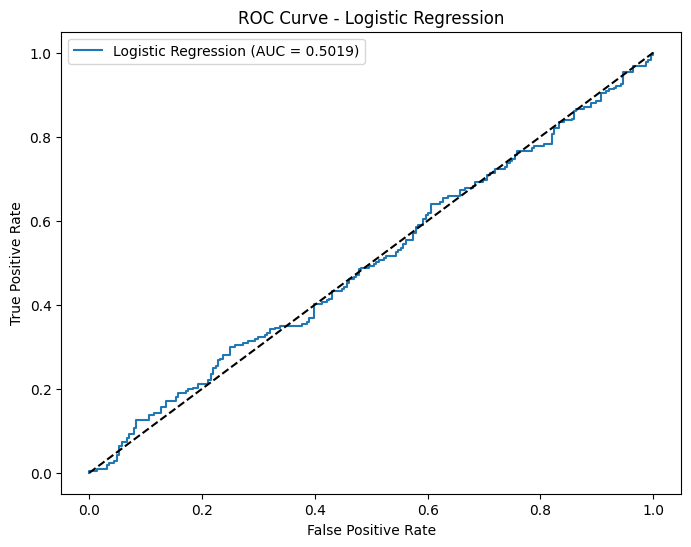

In [28]:
feature_columns = [
    'Day_Pct_Change', 'High_Low_Pct', 'Open_Close_Pct',
    'Moving_Avg_5', 'Moving_Avg_10', 'Moving_Avg_15', 'Moving_Avg_20',
    'Lag_1_Close', 'Lag_2_Close', 'Lag_3_Close',
    'SMA_20', 'Upper_BB', 'Lower_BB', 'RSI', 'MACD', 'Signal_Line',
    'Avg_Volume_5', 'Volume_Change'
]

X_train = train_df[feature_columns]
y_train = train_df['Target']

X_val = val_df[feature_columns]
y_val = val_df['Target']

X_test = test_df[feature_columns]
y_test = test_df['Target']

# Initialize and train the Logistic Regression model
model = LogisticRegression(max_iter=1000)  # Increased max_iter to ensure convergence
model.fit(X_train, y_train)

# Predicting probabilities and classes
y_val_pred_prob = model.predict_proba(X_val)[:, 1]
y_val_pred = model.predict(X_val)

y_test_pred_prob = model.predict_proba(X_test)[:, 1]
y_test_pred = model.predict(X_test)

# Evaluation
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
val_auc = roc_auc_score(y_val, y_val_pred_prob)
test_auc = roc_auc_score(y_test, y_test_pred_prob)

print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Validation AUC: {val_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")

print("\nClassification Report (Validation):")
print(classification_report(y_val, y_val_pred))

print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))

# Plot ROC Curve for Test Data
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.show()


Based on the new results, it seems that the additional features did not improve the performance of the Logistic Regression model. In fact, the AUC and overall accuracy have slightly dropped, and the model is heavily biased toward predicting the majority class (class 0).

The AUC scores have decreased compared to the initial model without the additional features. AUC close to 0.5 indicates that the model is performing similarly to random guessing.



# **Performing Feature Importance Analysis**

# **Logistic Regression Coefficients**

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Fit the Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

# Print coefficients
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': model.coef_[0]})
feature_importances = feature_importances.sort_values(by='Coefficient', ascending=False)
print(feature_importances)


           Feature  Coefficient
4    Moving_Avg_10     0.411923
5    Moving_Avg_15     0.225001
12        Lower_BB     0.197762
14            MACD     0.142753
3     Moving_Avg_5     0.062993
6    Moving_Avg_20     0.045936
10          SMA_20     0.045936
17   Volume_Change     0.037204
13             RSI    -0.001645
16    Avg_Volume_5    -0.014225
1     High_Low_Pct    -0.017874
0   Day_Pct_Change    -0.034037
2   Open_Close_Pct    -0.034037
11        Upper_BB    -0.088105
9      Lag_3_Close    -0.113392
15     Signal_Line    -0.154925
8      Lag_2_Close    -0.170511
7      Lag_1_Close    -0.650804


- Most Positive Coefficients: Features such as Moving_Avg_10, Moving_Avg_15, Lower_BB, and MACD have positive coefficients, suggesting that higher values of these features are associated with a higher probability of the target class (next day closing price being higher than the opening price).

- Most Negative Coefficients: Features like Lag_1_Close, Lag_2_Close, Signal_Line, and Upper_BB have negative coefficients, indicating an inverse relationship with the target.

# **Random Forest Feature Importances**

In [31]:
from sklearn.ensemble import RandomForestClassifier

# Fit a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)

# Get feature importances
importances = rf_model.feature_importances_
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances)


           Feature  Importance
17   Volume_Change    0.074028
16    Avg_Volume_5    0.069749
13             RSI    0.068946
1     High_Low_Pct    0.068784
2   Open_Close_Pct    0.065483
14            MACD    0.064953
0   Day_Pct_Change    0.064324
15     Signal_Line    0.063351
7      Lag_1_Close    0.049808
8      Lag_2_Close    0.048570
9      Lag_3_Close    0.048569
12        Lower_BB    0.048360
11        Upper_BB    0.046804
3     Moving_Avg_5    0.045500
4    Moving_Avg_10    0.045068
5    Moving_Avg_15    0.044535
10          SMA_20    0.042142
6    Moving_Avg_20    0.041028


Top Features: Volume_Change, Avg_Volume_5, RSI, High_Low_Pct, Open_Close_Pct, and MACD are some of the most important features according to the Random Forest model. This suggests that volume-based features and technical indicators are crucial in predicting stock price movements.

Lags and Averages: Lag features and moving averages are also deemed important, though slightly less so than volume-based and technical indicator features.

# **Permutation Importance**

In [32]:
from sklearn.inspection import permutation_importance

# Calculate permutation importance
results = permutation_importance(model, X_val_scaled, y_val, n_repeats=10, random_state=42, n_jobs=2)

# Get permutation importances
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': results.importances_mean})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances)


           Feature  Importance
13             RSI   -0.000901
16    Avg_Volume_5   -0.002027
1     High_Low_Pct   -0.003604
0   Day_Pct_Change   -0.004054
2   Open_Close_Pct   -0.004054
17   Volume_Change   -0.009234
14            MACD   -0.014414
8      Lag_2_Close   -0.015991
12        Lower_BB   -0.016892
11        Upper_BB   -0.017342
4    Moving_Avg_10   -0.018243
9      Lag_3_Close   -0.019369
5    Moving_Avg_15   -0.019595
7      Lag_1_Close   -0.020946
6    Moving_Avg_20   -0.028153
10          SMA_20   -0.028153
3     Moving_Avg_5   -0.033108
15     Signal_Line   -0.034685


Negative Impact on Performance: The permutation importance values indicate how much model performance decreases when each feature is shuffled. Features like Signal_Line, Moving_Avg_5, SMA_20, and Moving_Avg_20 show the most significant drops in performance when permuted, suggesting they are critical for the model's predictions.

Least Impactful Features: Some features have near-zero or slightly negative importance (e.g., RSI, Avg_Volume_5), indicating they may not be as impactful for the model's performance.

**Refining the feature set based on the feature importance analysis and re-training the logistic regression model**

In [33]:
# Step 1: Refine Feature Set
selected_features = ['Moving_Avg_10', 'Moving_Avg_15', 'Lower_BB', 'MACD', 'Volume_Change', 'Lag_1_Close']

X_train_selected = X_train[selected_features]
X_val_selected = X_val[selected_features]
X_test_selected = X_test[selected_features]

# Step 2: Standardize the Selected Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_val_scaled = scaler.transform(X_val_selected)
X_test_scaled = scaler.transform(X_test_selected)

# Step 3: Re-train the Logistic Regression Model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

# Step 4: Evaluate the Model
y_val_pred = model.predict(X_val_scaled)
y_test_pred = model.predict(X_test_scaled)

val_accuracy = model.score(X_val_scaled, y_val)
test_accuracy = model.score(X_test_scaled, y_test)
val_auc = roc_auc_score(y_val, model.predict_proba(X_val_scaled)[:, 1])
test_auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])

print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Validation AUC: {val_auc:.4f}')
print(f'Test AUC: {test_auc:.4f}')

print("\nClassification Report (Validation):")
print(classification_report(y_val, y_val_pred))

print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))


Validation Accuracy: 0.5248
Test Accuracy: 0.5191
Validation AUC: 0.5137
Test AUC: 0.5130

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.52      0.93      0.67       227
           1       0.58      0.10      0.17       217

    accuracy                           0.52       444
   macro avg       0.55      0.52      0.42       444
weighted avg       0.55      0.52      0.42       444


Classification Report (Test):
              precision    recall  f1-score   support

           0       0.52      0.84      0.64       228
           1       0.52      0.18      0.27       217

    accuracy                           0.52       445
   macro avg       0.52      0.51      0.46       445
weighted avg       0.52      0.52      0.46       445



The results of the logistic regression model with the refined feature set show some improvement in validation and test accuracy compared to previous attempts. However, the AUC scores and the precision-recall balance still indicate that the model isn't capturing the underlying patterns in the data effectively.

The accuracy scores for both the validation and test datasets are around 52%, which is slightly better than random guessing (50%). This suggests that the model has some predictive power but isn't very reliable.

The AUC scores for both validation (0.5137) and test (0.5130) are close to 0.5, indicating that the model's ability to distinguish between the two classes is not significantly better than random chance.

For class 0 (next day price down), the model has high recall but lower precision, meaning it correctly identifies many of the true negatives but also makes a fair number of false positives.
For class 1 (next day price up), both precision and recall are low, indicating difficulty in correctly identifying when the price will go up.